In [1]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [24]:
scRNA = readRDS('./after_rename.rds')

In [25]:
gene_cell_exp <- AverageExpression(scRNA,
                                   group.by = 'orig.ident',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)

In [26]:
gene_cell_exp = gene_cell_exp[,c(1,3,4,2)]

In [27]:
gene_filter <- gene_cell_exp[which(rowMeans(gene_cell_exp) >= 0.01), ]    

In [28]:
library(Mfuzz)

In [29]:
head(gene_filter,2)

,MI14d,MI7d,control,MI3d
,<dbl>,<dbl>,<dbl>,<dbl>
Xkr4,0.01827432,0.01824276,0.008222373,0.0007455624
Sox17,0.07608656,0.05254835,0.033293050,0.0178724088


In [30]:
gene_filter['Trem2',]

,MI14d,MI7d,control,MI3d
,<dbl>,<dbl>,<dbl>,<dbl>
Trem2,0.1523797,0.9964108,0.02153546,1.20464


In [31]:
gene_filter <- as.matrix(gene_filter)

0 genes excluded.
0 genes excluded.


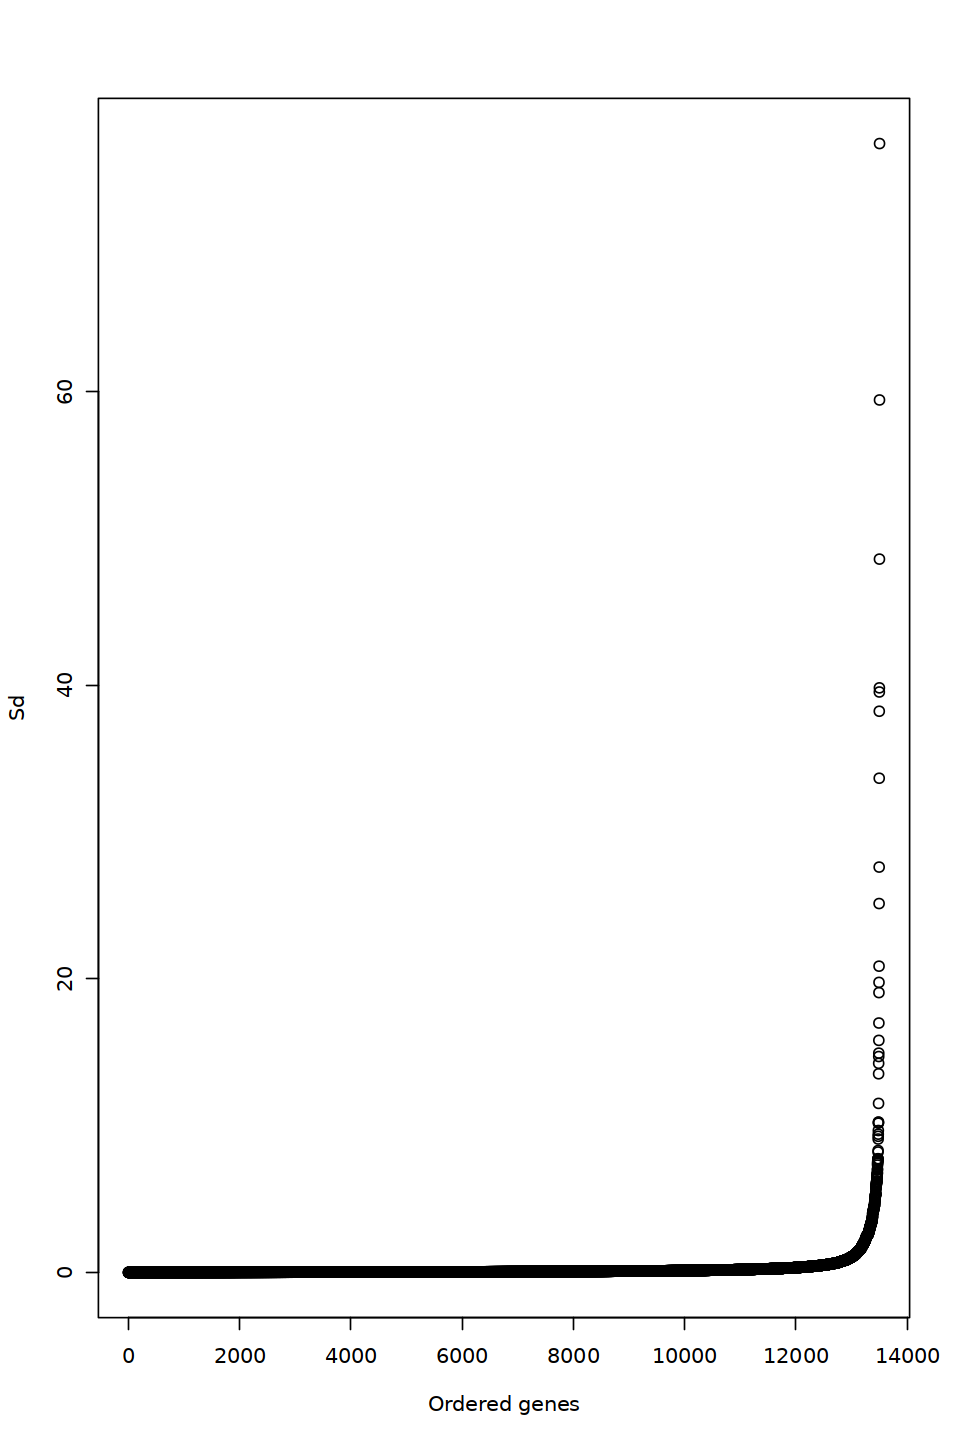

In [32]:
mfuzz_class <- new('ExpressionSet',exprs = gene_filter)
#预处理缺失值或者异常值
mfuzz_class <- filter.NA(mfuzz_class, thres = 0.25)
mfuzz_class <- fill.NA(mfuzz_class, mode = 'mean')
mfuzz_class <- filter.std(mfuzz_class, min.std = 0)

In [33]:
mfuzz_class <- standardise(mfuzz_class)

In [34]:
set.seed(123)
cluster_num <-8
mfuzz_cluster <- mfuzz(mfuzz_class, c = cluster_num, m = mestimate(mfuzz_class))

In [35]:
options(repr.plot.height = 12,repr.plot.width = 8)

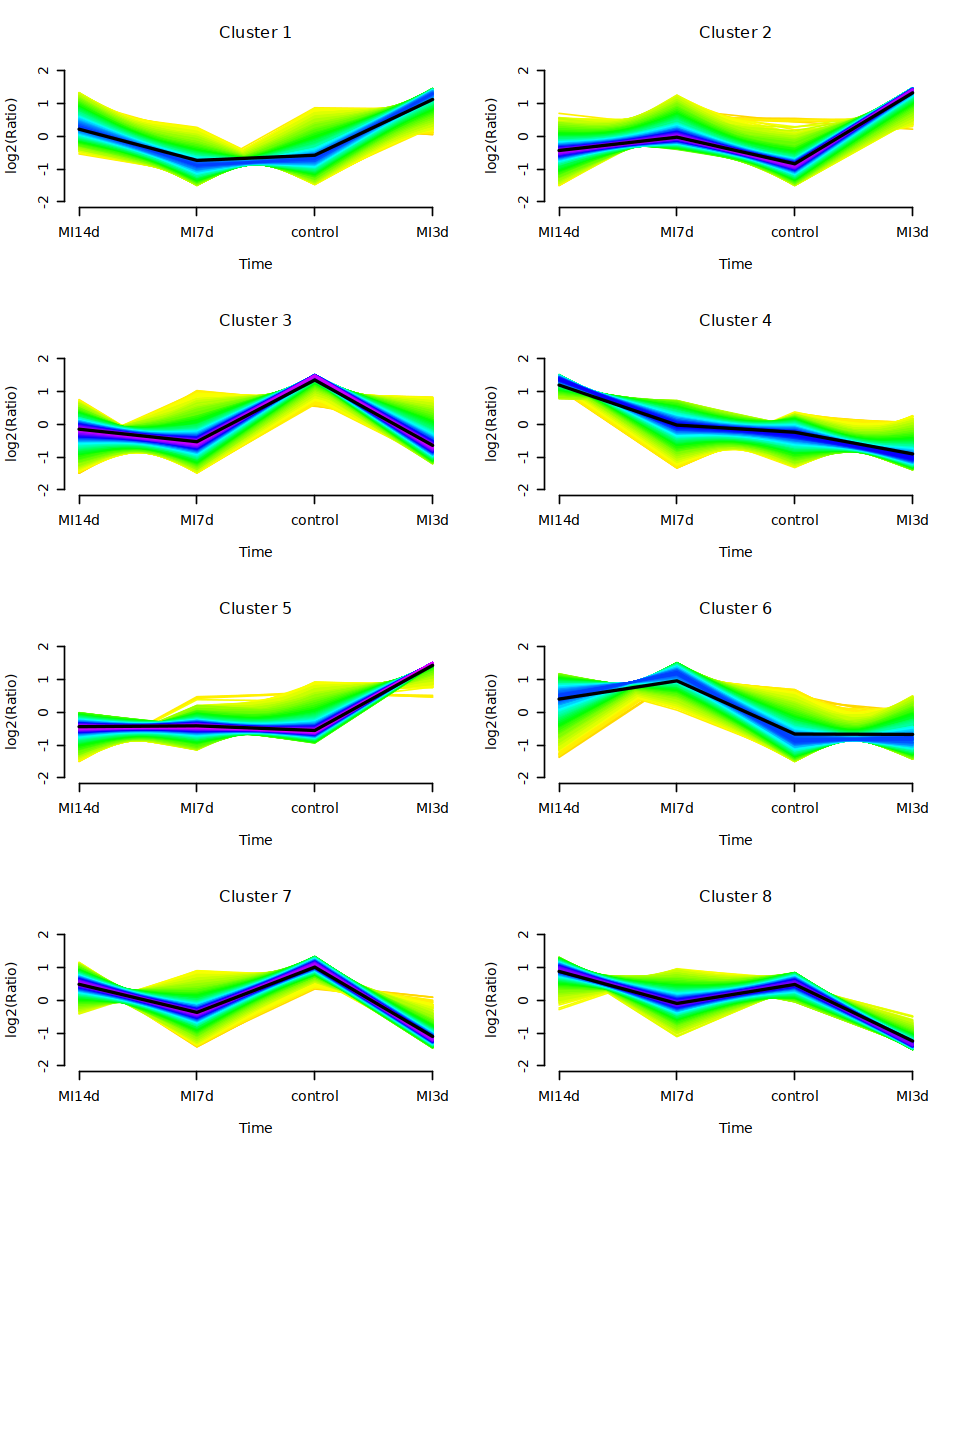

In [36]:
#pdf('figure9.pdf',height = 10,width = 6)
mfuzz.plot2(mfuzz_class, cl = mfuzz_cluster, mfrow = c(5, 2),
            centre=TRUE, centre.col="black",
            centre.lwd=2,time.labels = colnames(gene_filter),
            x11 = FALSE,ylab="log2(Ratio)",ylim.set=c(-2,2))
#dev.off()

In [17]:
#write.table(mfuzz_cluster$cluster,"outcluster.txt",quote=F,row.names=T,col.names=F,sep="\t")

#### cluster2中基因的富集分析

In [4]:
gene = read.table('./outcluster.txt')

In [5]:
head(gene,2)

,V1,V2
,<chr>,<int>
1,Xkr4,6
2,Sox17,4


In [19]:
library(dplyr)

Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following object is masked from ‘package:widgetTools’:

    funs


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [20]:
c5 = gene %>% filter(V2 ==2)

In [21]:
library(clusterProfiler)
library(org.Mm.eg.db)



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProf

In [22]:
gene_symbol <- bitr(geneID = c5$V1,  #感兴趣的基因集
                    fromType="SYMBOL",   #输入ID的类型
                    toType=c("ENTREZID"),   #输出ID的类型，可为多个
                    OrgDb="org.Mm.eg.db")

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(geneID = c5$V1, fromType = "SYMBOL", toType = c("ENTREZID"), :
“5.92% of input gene IDs are fail to map...”


In [23]:
gene <- gene_symbol[,2]
BP <- enrichGO(gene = gene,  #基因列表(转换的ID)
               keyType = "ENTREZID",  #指定的基因ID类型，默认为ENTREZID
               OrgDb=org.Mm.eg.db,  #物种对应的org包
               ont = "BP",   #CC细胞组件，MF分子功能，BP生物学过程
               pvalueCutoff = 0.05,  #p值阈值
               pAdjustMethod = "fdr",  #多重假设检验校正方式
               minGSSize = 10,   #注释的最小基因集，默认为10
               maxGSSize = 500,  #注释的最大基因集，默认为500
               qvalueCutoff = 0.05,  #q值阈值
               readable = TRUE)  #

In [24]:
bp <-clusterProfiler::simplify(BP)

In [25]:
library(topGO)

Warning message:
“package ‘topGO’ was built under R version 4.2.2”
Loading required package: graph

Warning message:
“package ‘graph’ was built under R version 4.2.3”
Loading required package: GO.db

Loading required package: SparseM

Warning message:
“package ‘SparseM’ was built under R version 4.2.3”

Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve



groupGOTerms: 	GOBPTerm, GOMFTerm, GOCCTerm environments built.


Attaching package: ‘topGO’


The following object is masked from ‘package:IRanges’:

    members




In [26]:
BP_ego <- pairwise_termsim(bp)

ERROR: Error in pairwise_termsim(bp): could not find function "pairwise_termsim"


In [ ]:
write.csv(BP_ego@result,file = 'BP_ego.csv')

In [ ]:
options(repr.plot.width = 10,repr.plot.height = 10)

In [ ]:
emapplot(BP_ego, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
  ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                        guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10') 

In [ ]:
ggsave('figure9a.pdf',height = 8,width = 8)

In [ ]:
gene <- gene_symbol[,2]

In [ ]:
ek <- enrichKEGG(gene =gene , 
               organism = "mmu",  
               pvalueCutoff =0.1, 
               qvalueCutoff = 0.1)

In [ ]:
KEGG2 <- pairwise_termsim(ek)

options(repr.plot.width = 10,repr.plot.height = 10)

emapplot(KEGG2, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
  ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                        guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10') 

In [ ]:
ggsave('figure9b.pdf',height = 8,width = 8)

In [ ]:
path1 = BP_ego@result %>%  filter(Description == 'regulation of immune effector process')

In [ ]:
gene =data.frame(gene = strsplit(path1[,8],split = '/'))

colnames(gene)= 'gene'
Idents(scRNA) ='orig.ident'
df <- as.data.frame(AverageExpression(object = scRNA)$RNA)

library(tidyr)

df %>%
    filter(row.names(.) %in% gene$gene) %>% 
    apply(., 1, function(y) (y - mean(y)) / sd(y) ^ as.logical(sd(y))) %>% 
          t() -> df2
          

In [ ]:
head(df2,3)

In [ ]:
df2 %>% as.data.frame() %>% 
    tibble::rownames_to_column(var = "gene")%>%
    right_join(gene) %>%
    pivot_longer(cols = `control`:`MI7d`, names_to = "cluster_name", values_to = "exp")%>%
    group_by(gene) %>%
    mutate(exp = as.numeric(scale(exp))) %>%
    ungroup() -> df3

In [ ]:
cluster_name <- c("control",'MI3d','MI7d','MI14d')

library(ggplot2)
options(repr.plot.width = 5,repr.plot.height = 15)
df3 %>% ggplot(aes(x = cluster_name,
               y = gene,
               fill = exp)) +
    geom_tile() +
    scale_fill_gradient2(low="#003366", high="#990033", mid="white") +
    scale_x_discrete(limits = cluster_name) +
  theme(axis.text.x =element_text(angle =45,hjust =0.5,vjust = 0.5))+ theme(text = element_text(size = 14))

In [ ]:
ggsave('figure9c-regulation_of_immune_effector_process.pdf',height = 14,width = 6)

In [ ]:
path2 = BP_ego@result %>%  filter(Description == 'leukocyte proliferation')

In [ ]:
gene =data.frame(gene = strsplit(path2[,8],split = '/'))

colnames(gene)= 'gene'

df <- as.data.frame(AverageExpression(object = scRNA)$RNA)

library(tidyr)

df %>%
    filter(row.names(.) %in% gene$gene) %>% 
    apply(., 1, function(y) (y - mean(y)) / sd(y) ^ as.logical(sd(y))) %>% 
          t() -> df2
          

df2 %>% as.data.frame() %>% 
    tibble::rownames_to_column(var = "gene")%>%
    right_join(gene) %>%
    pivot_longer(cols = `control`:`MI7d`, names_to = "cluster_name", values_to = "exp")%>%
    group_by(gene) %>%
    mutate(exp = as.numeric(scale(exp))) %>%
    ungroup() -> df3

cluster_name <- c("control",'MI3d','MI7d','MI14d')

library(ggplot2)
options(repr.plot.width = 6,repr.plot.height = 12)
df3 %>% ggplot(aes(x = cluster_name,
               y = gene,
               fill = exp)) +
    geom_tile() +
    scale_fill_gradient2(low="#003366", high="#990033", mid="white") +
    scale_x_discrete(limits = cluster_name) +
  theme(axis.text.x =element_text(angle =45,hjust =0.5,vjust = 0.5))+ theme(text = element_text(size = 14))

In [ ]:
ggsave('figure9d_leukocyte_proliferation.pdf',height = 12,width = 6)

In [ ]:
gene1 =data.frame(gene = strsplit(path1[,8],split = '/'))

In [ ]:
immu_leu = data.frame(intersect(gene1$c..Arid5a....Il18rap....Il10....Ptprc....Fcgr2b....Fcgr3....Fcer1g...,gene$gene))

In [ ]:
colnames(immu_leu) = 'gene'

In [ ]:
write.table(immu_leu,file = 'immu_leu.txt',quote =F,row.names = F)

In [ ]:
getwd()

### 基因集

In [ ]:
gene1 = read.table('./outcluster.txt')

In [ ]:
table(gene1$V2)

In [182]:
DefaultAssay(scRNA)  = 'RNA'
Idents(scRNA) = 'orig.ident'
object.markersa <- FindMarkers(scRNA, ident.1 = 'MI3d',ident.2 = 'control')

In [ ]:
DefaultAssay(scRNA)  = 'RNA'
Idents(scRNA) = 'orig.ident'
object.markersb <- FindMarkers(scRNA, ident.1 = 'MI3d',ident.2 = 'MI14d')

In [227]:
length(intersect(rownames(object.markersa),rownames(object.markersb)))

[1] 2198

In [184]:
tmp = list()

In [185]:

for ( i in c(1:8)){
    count = length(intersect(intersect(rownames(object.markersa),rownames(object.markersb)),gene1[gene1$V2 == i,1]))
    
    tmp = c(tmp,count)
}

,Var1,Freq,ID,hjust,angle
,<fct>,<int>,<dbl>,<dbl>,<dbl>
X39L,C1,39,1,0,82.173913
X578L,C2,578,2,0,66.521739
X86L,C3,86,3,0,50.869565
X55L,C4,55,4,0,35.217391
X679L,C5,679,5,0,19.565217
X56L,C6,56,6,0,3.913043
X358L,C7,358,7,0,-11.739130
X347L,C8,347,8,0,-27.391304


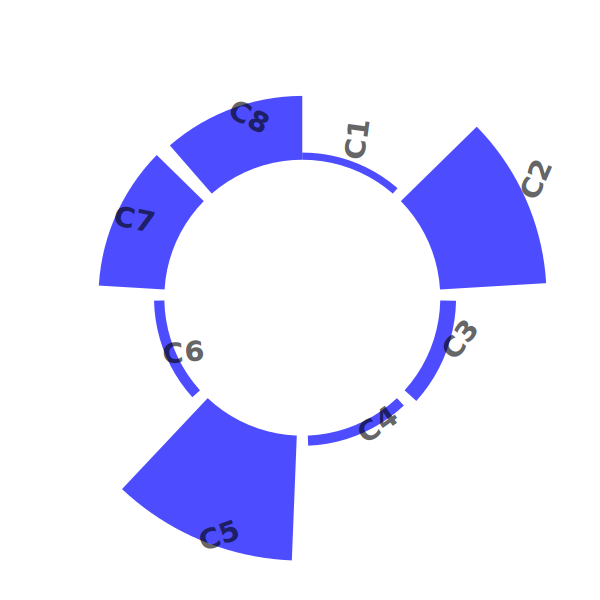

In [228]:
a = as.data.frame(t(as.data.frame(tmp)))

a$cluster = paste0('C',c(1:8))

a = a[,c(2,1)]

colnames(a) = c('Var1'	,'Freq')

a$Var1 = as.factor(a$Var1)

a$ID <- as.numeric(c(1:8))

number_of_bar <- nrow(a)
angle <-  90 - 360 * (a$ID-0.5) /23
a$hjust<-ifelse(angle < -90, 1, 0)
a$angle<-ifelse(angle < -90, angle+180, angle)

a

options(repr.plot.width = 5,repr.plot.height = 5)

p1 <- ggplot(a, aes(x=ID, y=Freq))+
  geom_bar(stat="identity", fill="blue", alpha=0.7) +
  ylim(-750,750) +#y轴范围，控制内圆大小与条形大小
  theme_minimal() +#主题
  theme(axis.text = element_blank(),
        axis.title = element_blank(),
        panel.grid = element_blank(),
        plot.margin = unit(rep(-1,4), "cm")) +#调整边缘以使得标签不会被截断
  coord_polar(start = 0) +#极坐标
  geom_text(data=a, aes(x=ID, y=Freq+10, label=Var1, hjust=hjust), 
            color="black", fontface="bold",alpha=0.6, size=6, 
            angle= a$angle, inherit.aes = F) #标签


p1

In [222]:
ggsave('figure9e-number-of-gene.pdf',height = 5,width = 5)

In [223]:
overlapgenen = intersect(rownames(object.markersa),rownames(object.markersb))

In [71]:
 gene_symbol <- bitr(geneID = overlapgenen,  #感兴趣的基因集
                    fromType="SYMBOL",   #输入ID的类型
                    toType=c("ENTREZID"),   #输出ID的类型，可为多个
                    OrgDb="org.Mm.eg.db")
gene <- gene_symbol[,2]
overlap <- enrichGO(gene = gene,  #基因列表(转换的ID)
               keyType = "ENTREZID",  #指定的基因ID类型，默认为ENTREZID
               OrgDb=org.Mm.eg.db,  #物种对应的org包
               ont = "BP",   #CC细胞组件，MF分子功能，BP生物学过程
               pvalueCutoff = 0.01,  #p值阈值
               pAdjustMethod = "fdr",  #多重假设检验校正方式
               minGSSize = 1,   #注释的最小基因集，默认为10
               maxGSSize = 500,  #注释的最大基因集，默认为500
               qvalueCutoff = 0.01,  #q值阈值
               readable = TRUE)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(geneID = overlapgenen, fromType = "SYMBOL", toType = c("ENTREZID"), :
“4.14% of input gene IDs are fail to map...”


In [225]:
library(clusterProfiler)
library(org.Mm.eg.db)
options(warn = -1)
tmp2 = list()
for ( i in c(1:8)){
    clustergene = gene1[gene1$V2 == i,1]
    gene_symbol <- bitr(geneID = clustergene,  #感兴趣的基因集
                    fromType="SYMBOL",   #输入ID的类型
                    toType=c("ENTREZID"),   #输出ID的类型，可为多个
                    OrgDb="org.Mm.eg.db")
gene <- gene_symbol[,2]
CC <- enrichGO(gene = gene,  #基因列表(转换的ID)
               keyType = "ENTREZID",  #指定的基因ID类型，默认为ENTREZID
               OrgDb=org.Mm.eg.db,  #物种对应的org包
               ont = "BP",   #CC细胞组件，MF分子功能，BP生物学过程
               pvalueCutoff = 0.01,  #p值阈值
               pAdjustMethod = "fdr",  #多重假设检验校正方式
               minGSSize = 1,   #注释的最小基因集，默认为10
               maxGSSize = 500,  #注释的最大基因集，默认为500
               qvalueCutoff = 0.01,  #q值阈值
               readable = TRUE)  #
    pathwaycount = length(intersect(CC@result[1:100,2],overlap@result[1:100,2]))
    tmp2 = c(tmp2,pathwaycount)
    
}

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



In [226]:
tmp2

[[1]]
[1] 1

[[2]]
[1] 37

[[3]]
[1] 13

[[4]]
[1] 8

[[5]]
[1] 20

[[6]]
[1] 20

[[7]]
[1] 24

[[8]]
[1] 18

,Var1,Freq,ID,hjust,angle
,<fct>,<int>,<dbl>,<dbl>,<dbl>
X1L,C1,1,1,0,82.173913
X37L,C2,37,2,0,66.521739
X13L,C3,13,3,0,50.869565
X8L,C4,8,4,0,35.217391
X20L,C5,20,5,0,19.565217
X20L.1,C6,20,6,0,3.913043
X24L,C7,24,7,0,-11.739130
X18L,C8,18,8,0,-27.391304


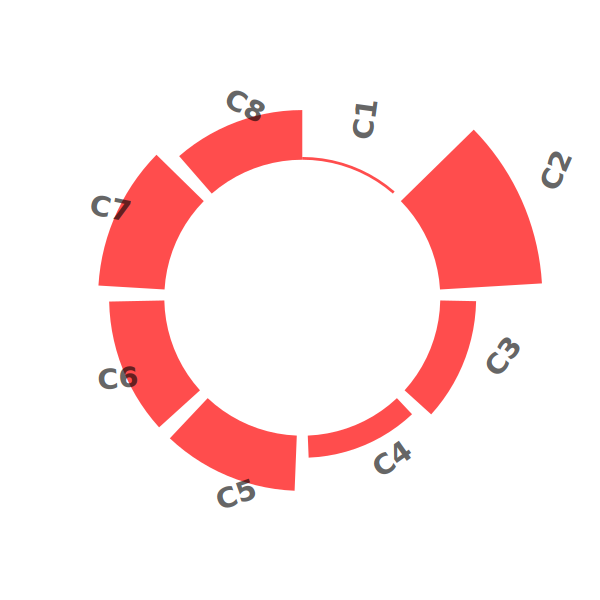

In [233]:
a = as.data.frame(t(as.data.frame(tmp2)))

a$cluster = paste0('C',c(1:8))

a = a[,c(2,1)]

colnames(a) = c('Var1'	,'Freq')

a$Var1 = as.factor(a$Var1)

a$ID <- as.numeric(c(1:8))

number_of_bar <- nrow(a)
angle <-  90 - 360 * (a$ID-0.5) /23
a$hjust<-ifelse(angle < -90, 1, 0)
a$angle<-ifelse(angle < -90, angle+180, angle)

a
options(repr.plot.width = 5,repr.plot.height = 5)

p1 <- ggplot(a, aes(x=ID, y=Freq))+
  geom_bar(stat="identity", fill="red", alpha=0.7) +
  ylim(-50,50) +#y轴范围，控制内圆大小与条形大小
  theme_minimal() +#主题
  theme(axis.text = element_blank(),
        axis.title = element_blank(),
        panel.grid = element_blank(),
        plot.margin = unit(rep(-1,4), "cm")) +#调整边缘以使得标签不会被截断
  coord_polar(start = 0) +#极坐标
  geom_text(data=a, aes(x=ID, y=Freq+10, label=Var1, hjust=hjust), 
            color="black", fontface="bold",alpha=0.6, size=6, 
            angle= a$angle, inherit.aes = F) #标签


p1

In [234]:
ggsave('figure9f-top100-pathway.pdf',height = 5,width = 5)

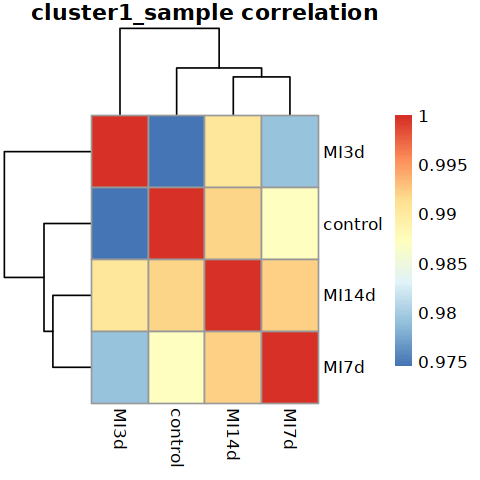

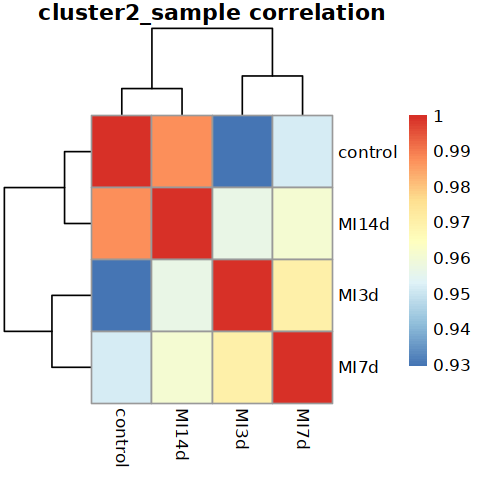

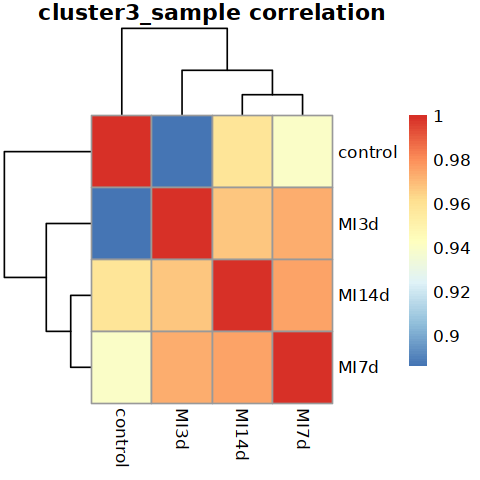

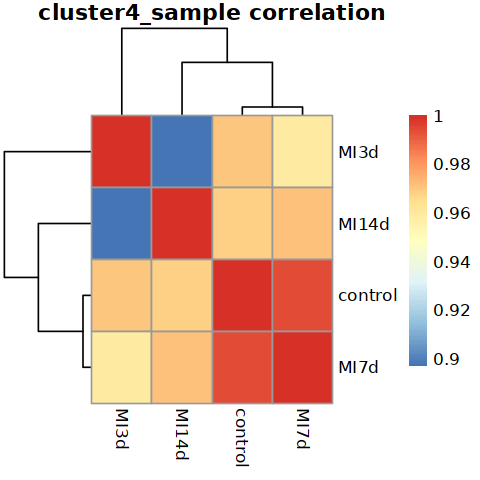

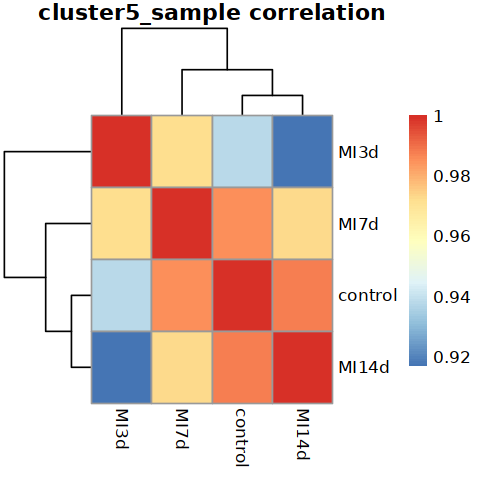

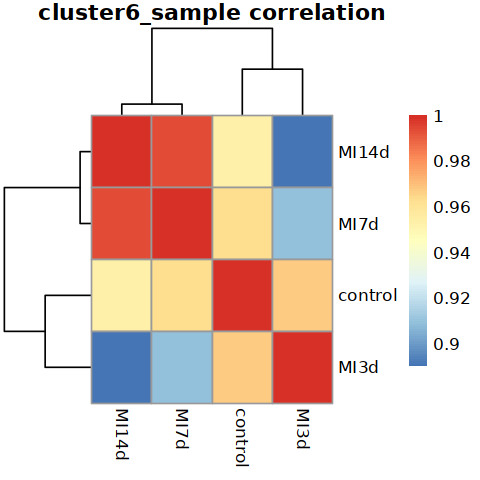

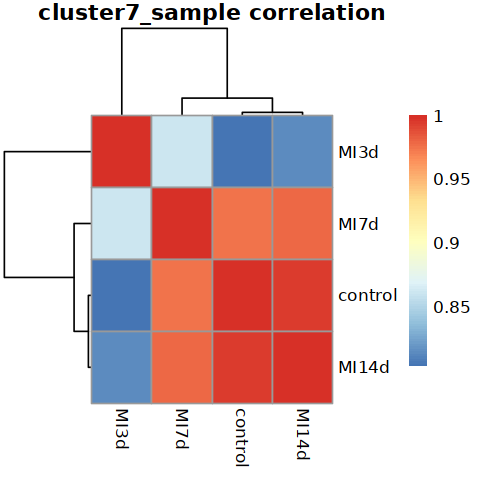

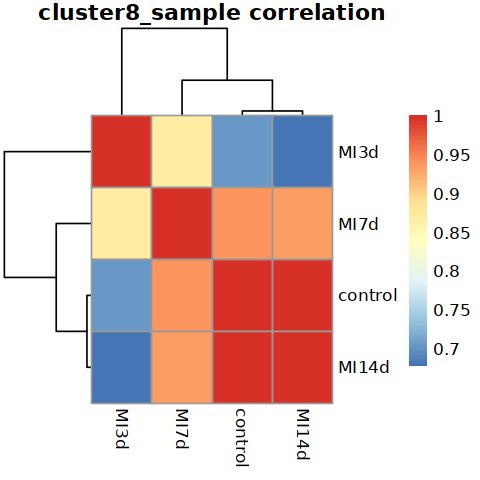

In [237]:
library(clusterProfiler)
library(org.Mm.eg.db)
options(warn = -1)
library(pheatmap)
Idents(scRNA)<- scRNA$orig.ident
av.exp1<- AverageExpression(scRNA)$RNA
options(repr.plot.width = 4,repr.plot.height = 4)
tmp = list()
for ( i in c(1:8)){
    clustergene = gene1[gene1$V2 == i,1]
    av.exp<- av.exp1[which(row.names(av.exp1)%in% clustergene),]
    
    av.exp <- cor(av.exp, method= "pearson")
    av.exp <- av.exp[apply(av.exp, 1, function(x) sd(x)!=0),]
    p = pheatmap::pheatmap(av.exp,main = paste0('cluster',i,'_sample correlation'))
    pdf(paste0('heatmap1/','cluster',i,'_sample correlation.pdf'))          
    print(p)
    dev.off()
    
}